In [14]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from scipy.stats.distributions import chi2
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [15]:
raw_data = yf.download(tickers = '^NSEI ^SPX', start = '2010-01-01', end = '2019-09-01',interval = '1d', group_by = 'ticker',auto_adjust = True, threads = True)
raw_data.head()
df = raw_data.copy()
df['nifty'] = raw_data['^NSEI'].Close[:]
df['spx'] = raw_data['^SPX'].Close[:]
df = df.iloc[1:]
del df['^NSEI']
del df['^SPX']
df = df.asfreq('b')
df['nifty'].fillna(method = 'ffill',inplace = True)
df['spx'].fillna(method = 'ffill',inplace = True)


[*********************100%***********************]  2 of 2 completed


In [16]:
df['Returns_n'] = df.nifty.pct_change(1)*100
df['Returns_s'] = df.spx.pct_change(1)*100
print(len(df['Returns_n']))
print(len(df['Returns_s']))
#df['Sq Returns'] = df['Returns'].mul(df['Returns'])

2519
2519


# SPLITTING THE DATA

In [17]:
size = int(len(df)*0.8)
df, df_test = df.iloc[:size], df.iloc[size:]
df.tail()

,nifty,spx,Returns_n,Returns_s
,,,,
Date,,,,
2017-09-19,10147.549805,2506.649902,-0.054661,0.111020
2017-09-20,10141.150391,2508.239990,-0.063064,0.063435
2017-09-21,10121.900391,2500.600098,-0.189821,-0.304592
2017-09-22,9964.400391,2502.219971,-1.556032,0.064779
2017-09-25,9872.599609,2496.659912,-0.921288,-0.222205


# Fitting simple AR

In [18]:
model_ar = ARIMA(df['nifty'],order = (1,0,0)).fit()

In [19]:
df['nifty'].tail()

Date
2017-09-19    10147.549805
2017-09-20    10141.150391
2017-09-21    10121.900391
2017-09-22     9964.400391
2017-09-25     9872.599609
Freq: B, Name: nifty, dtype: float64

In [20]:
start = '2017-09-26'
end = '2018-1-1'
ar_pred = model_ar.predict(start= start,end = end)
df.tail()

,nifty,spx,Returns_n,Returns_s
,,,,
Date,,,,
2017-09-19,10147.549805,2506.649902,-0.054661,0.111020
2017-09-20,10141.150391,2508.239990,-0.063064,0.063435
2017-09-21,10121.900391,2500.600098,-0.189821,-0.304592
2017-09-22,9964.400391,2502.219971,-1.556032,0.064779
2017-09-25,9872.599609,2496.659912,-0.921288,-0.222205


Text(0.5, 1.0, 'Predictions')

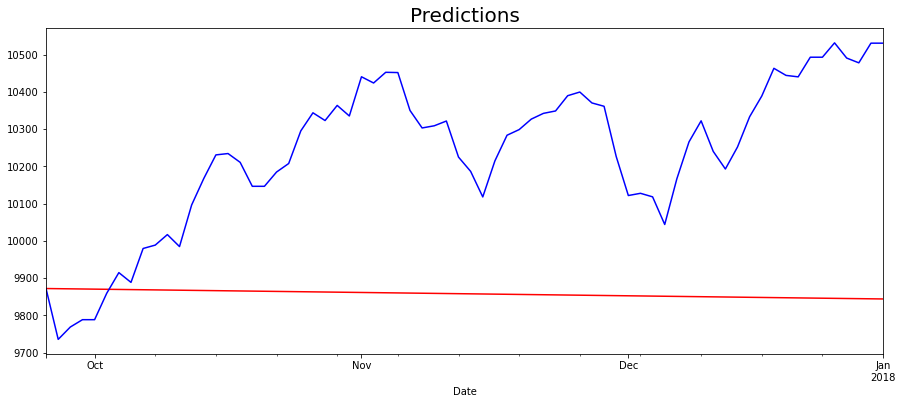

In [21]:
ar_pred[start:end].plot(figsize = (15,6), color = 'red')
df_test['nifty'][start:end].plot(color = 'blue')
plt.title('Predictions',size = 20)

# Using Returns in AR

Text(0.5, 1.0, 'Predictions of Returns')

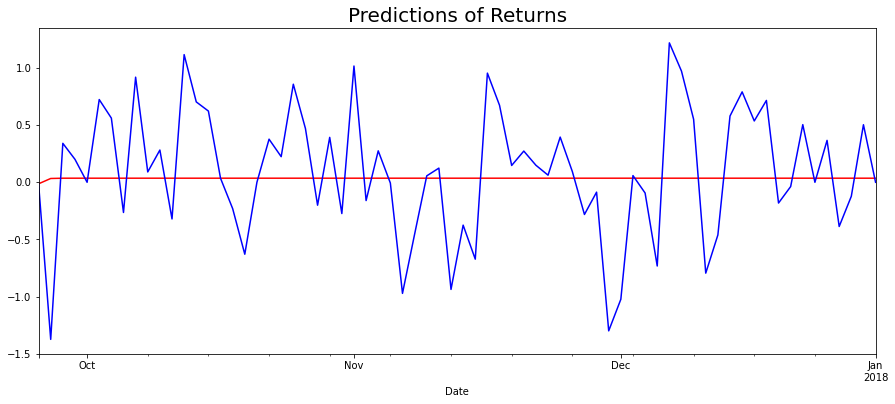

In [22]:
start = '2017-09-26'
end = '2018-1-1'
model_ar_ret = ARIMA(df['Returns_n'][1:],order = (1,0,0)).fit()
ar_pred_ret = model_ar_ret.predict(start= start,end = end)
ar_pred_ret[start:end].plot(figsize = (15,6), color = 'red')
df_test['Returns_n'][start:end].plot(color = 'blue')
plt.title('Predictions of Returns',size = 20)

# MA

Text(0.5, 1.0, 'Predictions of Returns')

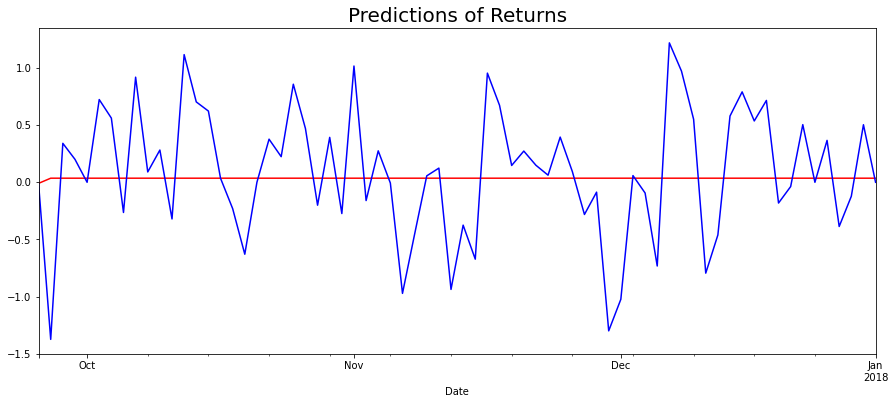

In [23]:
start = '2017-09-26'
end = '2018-1-1'
model_ma_ret = ARIMA(df['Returns_n'][1:],order = (0,0,1)).fit()
ma_pred_ret = model_ma_ret.predict(start= start,end = end)
ma_pred_ret[start:end].plot(figsize = (15,6), color = 'red')
df_test['Returns_n'][start:end].plot(color = 'blue')
plt.title('Predictions of Returns',size = 20)

# ARMAX

Text(0.5, 1.0, 'Predictions of Returns')

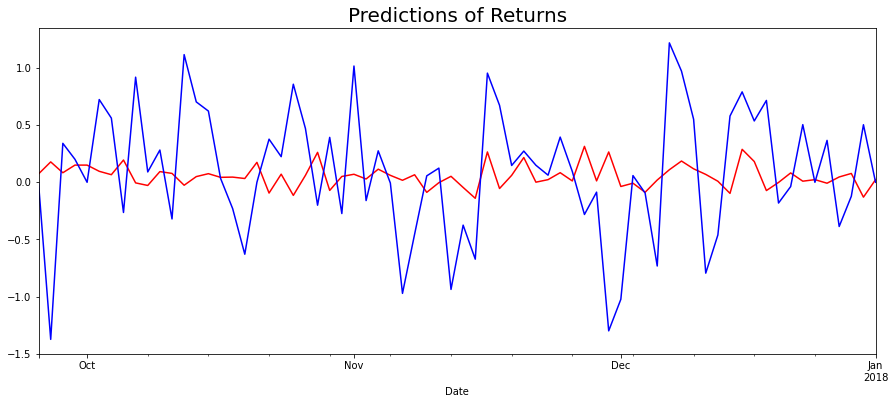

In [24]:
model_armax111 = ARIMA(df['Returns_n'][1:],order = (1,0,1),exog = df['Returns_s'][1:]).fit()
model_armax111_pred = model_armax111.predict(start = start, end = end, exog = df_test['Returns_s'][start:end])
model_armax111_pred[start:end].plot(figsize = (15,6), color = 'red')
df_test['Returns_n'][start:end].plot(color = 'blue')
plt.title('Predictions of Returns',size = 20)

# SARIMAX

Text(0.5, 1.0, 'Predictions of Returns')

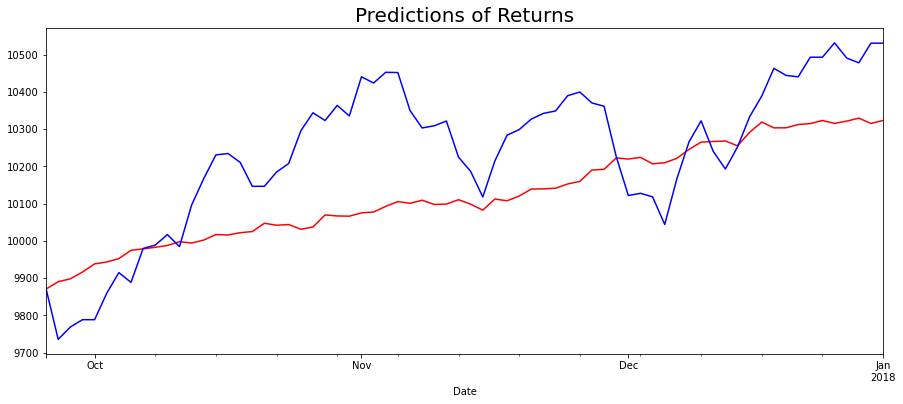

In [29]:
model_sarimax = SARIMAX(df['nifty'][1000:],order = (1,1,1),exog = df['spx'][1000:],seasonal_order = (2,1,1,5)).fit()
model_sarimax_pred = model_sarimax.predict(start = start, end = end, exog = df_test['spx'][start:end])
model_sarimax_pred[start:end].plot(figsize = (15,6), color = 'red')
df_test['nifty'][start:end].plot(color = 'blue')
plt.title('Predictions of Returns',size = 20)

In [35]:
df['sarimax'] = model_sarimax.resid
print('Mean of residuals is:',df.sarimax.mean())
print('Volatility of residuals is:',np.sqrt(df.sarimax.var()))

Mean of residuals is: 1.7106321350598117
Volatility of residuals is: 151.75846804071844
